In [13]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd

num_group_of_4 = 8  # Number of groups with 4 members
num_group_of_3 = 2  # Number of groups with 3 members
# input_file = 'aip-clustering/authors_list_partial.csv'
input_file = 'aip-clustering/authors_list_mpnet_partial.csv'
objective_type = 'minimize_max_distance'  # Options: 'maximize_min_distance' or 'minimize_max_distance'
# objective_type = 'maximize_min_distance'  # Options: 'maximize_min_distance' or 'minimize_max_distance'

df = pd.read_csv(input_file)

N = df.shape[0]
G = num_group_of_4 + num_group_of_3
assert N == num_group_of_4 * 4 + num_group_of_3 * 3, "The total number of points does not match the total group sizes."

group_sizes = [4]*num_group_of_4 + [3]*num_group_of_3  # List of group sizes
points = range(N)
groups = range(G)

author_names = df['author'].values
coordinates = df[['x_coordinate', 'y_coordinate']].values
x_coords = coordinates[:, 0]
y_coords = coordinates[:, 1]

# Calculate distance matrix
D = np.zeros((N, N))
for i in points:
    for j in points:
        D[i, j] = np.hypot(x_coords[i] - x_coords[j], y_coords[i] - y_coords[j])

# Create model
m = gp.Model("Grouping")

# Decision variables x_{i,k}
x = m.addVars(points, groups, vtype=GRB.BINARY, name="x")

# Auxiliary variables y_{i,j,k}
y = m.addVars(points, points, groups, vtype=GRB.BINARY, name="y")

# Variables for minimum or maximum distance
if objective_type == 'maximize_min_distance':
    D_min = m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name="D_min")
elif objective_type == 'minimize_max_distance':
    D_max = m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name="D_max")
else:
    raise ValueError("Invalid objective_type. Choose 'maximize_min_distance' or 'minimize_max_distance'.")

# Constraint 1: Each point is assigned to exactly one group
for i in points:
    m.addConstr(gp.quicksum(x[i, k] for k in groups) == 1, name=f"Assign_{i}")

# Constraint 2: Each group has the specified number of points
for k in groups:
    m.addConstr(gp.quicksum(x[i, k] for i in points) == group_sizes[k], name=f"GroupSize_{k}")

# Constraint 3: Define y_{i,j,k}
for i in points:
    for j in points:
        if i < j:
            for k in groups:
                m.addConstr(y[i, j, k] <= x[i, k], name=f"y_xik_{i}_{j}_{k}")
                m.addConstr(y[i, j, k] <= x[j, k], name=f"y_xjk_{i}_{j}_{k}")
                m.addConstr(y[i, j, k] >= x[i, k] + x[j, k] - 1, name=f"y_xi_xj_{i}_{j}_{k}")

# Constraint 4: Distance constraints
if objective_type == 'maximize_min_distance':
    for i in points:
        for j in points:
            if i < j:
                for k in groups:
                    m.addConstr(D[i, j] * y[i, j, k] >= D_min, name=f"Dmin_{i}_{j}_{k}")
    # Objective: Maximize D_min
    m.setObjective(D_min, GRB.MAXIMIZE)

elif objective_type == 'minimize_max_distance':
    for i in points:
        for j in points:
            if i < j:
                for k in groups:
                    m.addConstr(D[i, j] * y[i, j, k] <= D_max, name=f"Dmax_{i}_{j}_{k}")
    # Objective: Minimize D_max
    m.setObjective(D_max, GRB.MINIMIZE)

# Optimize
m.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i9-13900H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Academic license 2565624 - for non-commercial use only - registered to ur___@g.ecc.u-tokyo.ac.jp
Optimize a model with 28168 rows, 14821 columns and 64030 nonzeros
Model fingerprint: 0x5e69dfb2
Variable types: 1 continuous, 14820 integer (14820 binary)
Coefficient statistics:
  Matrix range     [7e-02, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 3.9776433
Presolve removed 9 rows and 7413 columns
Presolve time: 0.20s
Presolved: 28159 rows, 7408 columns, 64009 nonzeros
Variable types: 1 continuous, 7407 integer (7407 binary)

Root relaxation: objective 0.000000e+00, 771 iterations, 0.08 seconds (0.10 work units)

    Nodes    |    Current Node    | 


Group 1:
 Point IDs: [27, 30, 31, 36]
 Names: ['Miyagi Ryota' 'NGUYEN Hong Huy' 'Tomoki Ono' 'Hamada Rizk']
 Max distance within group: 0.9826654436509914

Group 2:
 Point IDs: [8, 13, 18, 29]
 Names: ['Tatsuya Kubo' 'Xing Zhang' 'AprilPyoneMaungMaung' 'Hanrui Wang']
 Max distance within group: 1.0618025109106919

Group 3:
 Point IDs: [3, 15, 19, 21]
 Names: ['Kyosuke Hatsugai' 'Kota Sugimoto' 'Tatsuya Kaneko' 'Yusuke Sugizaki']
 Max distance within group: 0.8132256088756304

Group 4:
 Point IDs: [11, 32, 34, 35]
 Names: ['Norihisa Namura' 'Kanoh Ryuichi' 'Noriaki Hashimoto' 'Hiroyuki Hanada']
 Max distance within group: 0.7395065149519648

Group 5:
 Point IDs: [9, 17, 23, 33]
 Names: ['Jin Nakazato' 'Yosuke Kawasaki' 'Awane Aika' 'Sato Motoaki']
 Max distance within group: 0.9359699233746559

Group 6:
 Point IDs: [10, 24, 26, 37]
 Names: ['Mika Oki' 'Yoshiki WATANABE' 'Tokio Takada' 'Yuki Ogasawara']
 Max distance within group: 0.9999185427145248

Group 7:
 Point IDs: [1, 7, 16, 22]


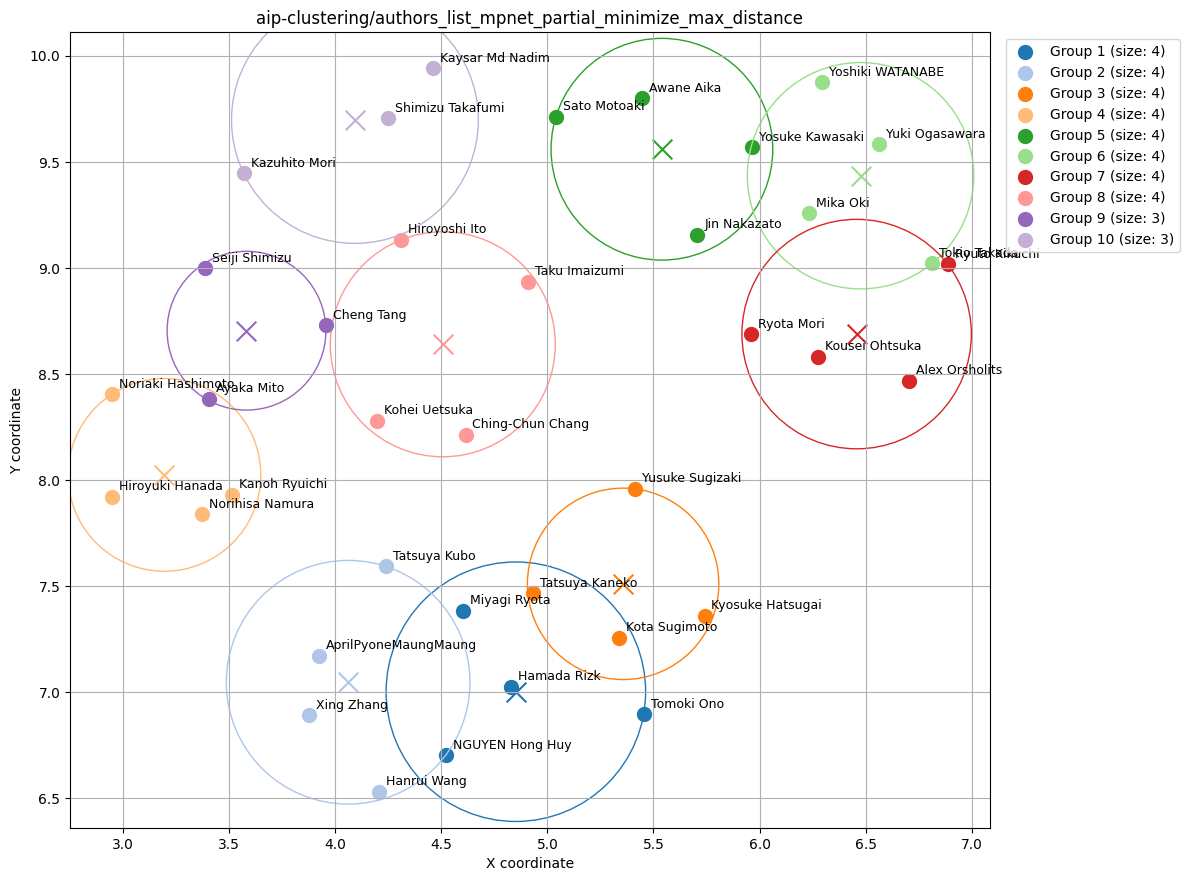

In [14]:
import matplotlib.pyplot as plt

# Set up group_color map
cmap = plt.get_cmap('tab20')  # 20 colors
colors = [cmap(i) for i in range(G)]

# Create figure and axis with equal aspect ratio
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_aspect('equal', 'box')

for k in groups:
    group_points = [i for i in points if x[i, k].X > 0.5]
    group_coords = coordinates[group_points]
    group_names = author_names[group_points]
    group_color = colors[k % len(colors)]

    # Plot group points
    ax.scatter(group_coords[:, 0], group_coords[:, 1], c=[group_color], s=100, label=f'Group {k+1} (size: {group_sizes[k]})')
    # Annotate each point with the author's name
    for i, txt in enumerate(group_names):
        ax.annotate(txt, (group_coords[i, 0], group_coords[i, 1]), fontsize=9, xytext=(5,5), textcoords='offset points')

    if objective_type == 'minimize_max_distance':
        # Calculate centroid of the group
        centroid = np.mean(group_coords, axis=0)
        # Calculate distances from centroid to each point, get max distance
        distances = np.linalg.norm(group_coords - centroid, axis=1)
        radius = np.max(distances)
        # Draw circle around the group
        circle = plt.Circle((centroid[0], centroid[1]), radius, color=group_color, fill=False, linestyle='-')
        ax.add_artist(circle)
        # Plot centroid
        ax.scatter(centroid[0], centroid[1], c=[group_color], marker='x', s=200)
    
    else:
        # Sort points in the group by angle
        center = np.mean(group_coords, axis=0)
        angles = np.arctan2(group_coords[:, 1] - center[1], group_coords[:, 0] - center[0])
        sorted_indices = np.argsort(angles)
        # Plot convex hull around the group
        polygon_coords = group_coords[sorted_indices]
        # Close the polygon using breaking point
        polygon = plt.Polygon(polygon_coords, fill=False, edgecolor=group_color, linestyle='-')
        ax.add_patch(polygon)

    print(f"\nGroup {k+1}:")
    print(f" Point IDs: {group_points}")
    print(f" Names: {group_names}")
    if objective_type == 'minimize_max_distance':
        # Calculate maximum distance within the group
        max_distance = np.max(D[group_points][:, group_points])
        print(f" Max distance within group: {max_distance}")
    else:
        #  Calculate minimum distance within the group
        min_distance = np.min(D[group_points][:, group_points])
        print(f" Min distance within group: {min_distance}")

ax.set_title(f"{input_file.split('.')[0]}_{objective_type}")
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.grid(True)
# Place legend outside the plot
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{input_file.split('.')[0]}_{ objective_type.replace('_', '-')}.png", bbox_inches='tight')
plt.show()